In [80]:
import numpy as np
import pandas as pd
import pathlib
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Activation, BatchNormalization,Dropout, MaxPooling1D,Flatten,Dense
from keras.utils import to_categorical
from tensorflow.keras import models
from IPython import display
import os
from sklearn.utils import shuffle
from os.path import isdir, join
from pathlib import Path
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import tensorflow as tf

In [81]:
# Set seed for experiment reproducibility
seed = 16
tf.random.set_seed(seed)
np.random.seed(seed)

In [82]:
#data generation
tf.keras.utils.get_file(
    'mini_speech_commands.zip',
     origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
     extract=True,
     cache_dir='.', cache_subdir='data')
data_dir = pathlib.Path('/content/data/mini_speech_commands')

In [83]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['yes' 'go' 'no' 'up' 'left' 'down' 'right' 'stop']


In [84]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print(num_samples)

8000


In [85]:
filenames[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'/content/data/mini_speech_commands/stop/0132a06d_nohash_4.wav'>

In [86]:
check = filenames[0].numpy()
check

b'/content/data/mini_speech_commands/stop/0132a06d_nohash_4.wav'

In [87]:
check.decode("utf-8")

'/content/data/mini_speech_commands/stop/0132a06d_nohash_4.wav'

In [88]:
sample_rate , samples = wavfile.read(check)

In [89]:
samples.shape

(16000,)

In [90]:
freq, time, spectrogram = signal.spectrogram(samples , fs = sample_rate)

In [91]:
# fig = plt.figure(figsize=(14, 8))


# ax1 = fig.add_subplot(211)

# ax1.set_ylabel('Amplitude')
# ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)



# ax2 = fig.add_subplot(212)
# ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
#            extent=[time.min(), time.max(), freq.min(), freq.max()])
# ax2.set_yticks(freq[::16])
# ax2.set_xticks(time[::16])

# ax2.set_ylabel('Freqs in Hz')
# ax2.set_xlabel('Seconds')

# # plt.show()

In [93]:
samples, sample_rate = librosa.load(check)

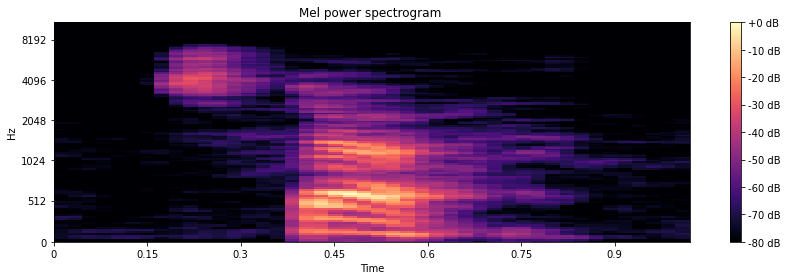

In [94]:
spect = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)
log_spect = librosa.power_to_db(spect, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_spect, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [95]:
filename = []

for f in filenames:
  filename.append(f.numpy().decode("utf-8"))
# filename

sample_rates=[]
samples = []
label = []
for f in filename:
  smpl,smpl_rt = librosa.load(f)
  smpl = librosa.resample(smpl,smpl_rt,8000)
  samples.append(smpl)
  sample_rates.append(8000)
  label.append(f.rsplit("/",2)[1])
# samples
df = pd.DataFrame()
df['Sample'] = samples
df['Sample_Rate'] = sample_rates
df["Label"] = label
df

,Sample,Sample_Rate,Label
0,"[-7.6012075e-05, -0.00039937985, -0.0006083583...",8000,stop
1,"[0.00014733513, 6.0848917e-05, -0.00018095208,...",8000,no
2,"[-0.00018198133, -0.00033874318, -0.0002097902...",8000,right
3,"[-0.00056744023, 0.00023026753, 0.0011649787, ...",8000,right
4,"[0.0016161515, 0.0046419827, 0.008236466, 0.00...",8000,stop
...,...,...,...
7995,"[0.00386812, 0.0070186667, 0.007101933, 0.0074...",8000,no
7996,"[-0.0001560897, -0.00035819216, -4.9689308e-05...",8000,stop
7997,"[-0.00016574738, -0.0020635838, -0.0029040675,...",8000,left
7998,"[-2.7127564e-05, 8.400315e-05, 7.836971e-05, -...",8000,down


In [123]:
df.describe()

,Sample_Rate
count,8000.0
mean,8000.0
std,0.0
min,8000.0
25%,8000.0
50%,8000.0
75%,8000.0
max,8000.0


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sample       8000 non-null   object
 1   Sample_Rate  8000 non-null   int64 
 2   Label        8000 non-null   object
dtypes: int64(1), object(2)
memory usage: 187.6+ KB


In [125]:
df.isnull().sum()

Sample         0
Sample_Rate    0
Label          0
dtype: int64

In [99]:
df.isnull().sum()

Sample         0
Sample_Rate    0
Label          0
dtype: int64

In [126]:
count = df["Label"].value_counts()
count

right    1000
yes      1000
down     1000
left     1000
up       1000
go       1000
stop     1000
no       1000
Name: Label, dtype: int64

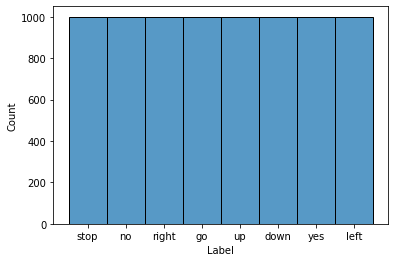

In [127]:
sns.histplot(data = df , x = 'Label' )
plt.show()

In [128]:
def plot_spect(sample_rate , samples , label , val):
  fig = plt.figure(figsize=(14, 8))
  ax = fig.add_subplot(8 , 1 , val )
  ax.set_ylabel('Amplitude')
  plt.title(label)
  ax.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [103]:
'''
val = 1

for i in range(df.shape[0]):
  plot_spect(df['Sample_Rate'][i] , df['Sample'][i] , df['Label'][i], val )
  val = val + 1
'''

"\nval = 1\n\nfor i in range(df.shape[0]):\n  plot_spect(df['Sample_Rate'][i] , df['Sample'][i] , df['Label'][i], val )\n  val = val + 1\n"

In [129]:
encode_label = {'Label' : {'go' : 0 , 'up' : 1 , 'stop' : 2 , 'no' : 3 , 'down' : 4 ,
                           'yes' : 5 , 'right' : 6 , 'left' :7}}

In [130]:
dfr = df.replace(encode_label)
dfr.head(n=10)

,Sample,Sample_Rate,Label
0,"[-7.6012075e-05, -0.00039937985, -0.0006083583...",8000,2
1,"[0.00014733513, 6.0848917e-05, -0.00018095208,...",8000,3
2,"[-0.00018198133, -0.00033874318, -0.0002097902...",8000,6
3,"[-0.00056744023, 0.00023026753, 0.0011649787, ...",8000,6
4,"[0.0016161515, 0.0046419827, 0.008236466, 0.00...",8000,2
5,"[0.0013857705, 0.0034491864, 0.0042296564, 0.0...",8000,0
6,"[-0.000120132434, -0.0016094118, -0.0029186795...",8000,1
7,"[0.00019457292, 0.0007600711, 0.00034040553, -...",8000,1
8,"[-0.0026423142, -0.0038491387, -0.0039986665, ...",8000,1
9,"[-0.0015159113, -0.0023767743, -0.0021987108, ...",8000,2


In [131]:
dfr.shape

(8000, 3)

In [132]:
#dfr = dataframe
array = dfr.pop('Sample')
df_re = pd.concat([array.apply(pd.Series), dfr['Sample_Rate'] , dfr['Label']], axis=1)

In [108]:
array.apply(pd.Series).shape

(8000, 8000)

In [133]:
df_re.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7962,7963,7964,7965,7966,7967,7968,7969,7970,7971,7972,7973,7974,7975,7976,7977,7978,7979,7980,7981,7982,7983,7984,7985,7986,7987,7988,7989,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999,Sample_Rate,Label
0,-0.000076,-0.000399,-0.000608,-0.000457,-2.287428e-04,-0.000030,0.000214,-0.000065,0.000027,0.000170,0.000085,0.000152,0.000108,-0.000188,0.000024,0.000205,-0.000313,-0.000202,-0.000706,-0.000844,-0.000108,-0.000134,0.000144,0.000256,-0.000132,-0.000091,-0.000269,-0.000443,-0.000021,0.000127,0.000233,-0.000125,-0.000276,0.000193,0.000019,0.000247,0.000374,0.000231,0.000414,0.000310,...,-0.000643,-0.000436,0.000123,0.000426,0.000173,-0.000143,-0.000222,0.000015,0.000137,-0.000075,-0.000328,-0.000644,-0.000655,-0.000168,0.000096,-0.000199,-0.000864,-0.000813,-0.000215,-0.000472,-0.000311,-0.000168,-0.000393,-0.000381,-0.000296,0.000236,-0.000098,-0.000516,-0.000166,0.000429,0.001020,0.000518,-0.000147,-0.000398,-0.000027,0.000503,0.000300,0.000388,8000,2
1,0.000147,0.000061,-0.000181,-0.000135,-9.100668e-07,0.000134,0.000050,0.000032,0.000005,0.000019,-0.000070,-0.000142,-0.000177,-0.000180,-0.000067,0.000075,0.000081,0.000025,0.000234,0.000285,0.000125,0.000234,0.000201,-0.000039,-0.000149,-0.000226,-0.000134,-0.000008,-0.000114,-0.000131,0.000042,0.000192,0.000233,-0.000029,-0.000126,-0.000058,-0.000133,-0.000073,-0.000149,-0.000254,...,0.002554,0.002472,0.002065,0.001585,0.000930,0.000075,-0.000633,-0.001271,-0.001994,-0.002587,-0.002790,-0.002659,-0.002483,-0.002376,-0.002068,-0.001402,-0.000614,0.000120,0.000631,0.001177,0.001796,0.002362,0.002894,0.002905,0.002743,0.002463,0.001885,0.001247,0.000394,-0.000498,-0.001276,-0.001882,-0.002448,-0.002422,-0.002434,-0.002331,-0.001757,-0.001269,8000,3
2,-0.000182,-0.000339,-0.000210,-0.000090,8.769299e-05,-0.000105,0.000076,0.000291,0.000067,0.000150,0.000171,0.000425,-0.000063,-0.000194,-0.000073,0.000193,0.000235,0.000094,0.000366,0.000036,0.000214,-0.000081,0.000165,-0.000280,-0.000420,-0.000122,-0.000532,-0.000361,-0.000563,0.000047,-0.000094,-0.000018,-0.000079,-0.000164,-0.000106,-0.000185,0.000118,-0.000142,0.000064,0.000067,...,0.000183,0.000200,0.000108,0.000230,0.000160,0.000104,0.000019,0.000108,0.000079,0.000013,-0.000152,-0.000264,-0.000249,-0.000469,-0.000178,-0.000239,-0.000160,-0.000080,0.000085,-0.000015,0.000099,0.000228,0.000080,0.000191,0.000400,0.000315,-0.000136,0.000079,0.000161,0.000096,-0.000164,-0.000165,-0.000221,-0.000208,-0.000101,-0.000037,0.000255,0.000274,8000,6
3,-0.000567,0.000230,0.001165,0.001900,2.152750e-03,0.000893,-0.000338,0.000699,-0.000435,-0.000649,-0.000389,-0.000239,0.000556,0.000566,0.001043,0.000682,-0.000490,-0.001722,-0.002277,-0.002474,-0.002715,-0.001978,-0.000209,0.000299,0.000888,0.000750,0.001024,0.000078,0.000076,-0.000049,-0.000975,0.002084,0.001452,0.000427,0.000651,0.000468,0.000665,-0.000640,-0.001768,-0.003180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000,6
4,0.001616,0.004642,0.008236,0.007981,6.814431e-03,0.006609,0.004005,0.003044,0.000162,-0.001836,0.001813,0.000786,-0.001012,0.000086,0.001148,0.002198,0.003106,0.007343,0.009282,0.006578,0.005028,0.004513,0.002300,-0.001868,-0.001486,0.001239,0.000657,0.001110,0.000316,0.002687,0.002213,-0.000057,-0.000439,-0.001467,0.000586,0.001716,0.001630,-0.000428,-0.000132,0.000177,...,0.003182,0.001879,0.000977,0.003940,0.003599,0.004568,0.006141,0.006845,0.007170,0.005139,0.004946,0.003053,0.002795,0.003344,-0.000034,0.001831,0.003599,0.003879,0.001711,0.001030,0.005341,0.004558,0.004440,0.002691,0.000092,0.000415,-0.000503,-0.000865,-0.000722,-0.001713,0.000815,0.002925,0.003875,0.005277,0.007401,0.007697,0.006398,0.005862,8000,2


In [134]:
dropped = df_re.dropna(axis=0)

In [135]:
dropped.shape

(7178, 8002)

In [136]:
val_count = df_re['Label'].value_counts()
val_count

7    1000
3    1000
6    1000
2    1000
5    1000
1    1000
4    1000
0    1000
Name: Label, dtype: int64

In [137]:
val_count = dropped["Label"].value_counts()
val_count

7    930
4    912
2    911
5    908
6    904
3    880
0    874
1    859
Name: Label, dtype: int64

In [138]:
'''
col = [i for i in range(16000)]
str_col = [str(col[i]) for i in range(16000) ]
str_col[0:4]
'''

'\ncol = [i for i in range(16000)]\nstr_col = [str(col[i]) for i in range(16000) ]\nstr_col[0:4]\n'

In [139]:
'''
f = pd.DataFrame()
for i in range(8000):
  for j in range(len(features["Sample"][i])):
    f[str_col[j]] = features['Sample'][i][j]
'''

'\nf = pd.DataFrame()\nfor i in range(8000):\n  for j in range(len(features["Sample"][i])):\n    f[str_col[j]] = features[\'Sample\'][i][j]\n'

Dataset split

In [141]:
#df_re
dropped.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7962,7963,7964,7965,7966,7967,7968,7969,7970,7971,7972,7973,7974,7975,7976,7977,7978,7979,7980,7981,7982,7983,7984,7985,7986,7987,7988,7989,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999,Sample_Rate,Label
0,-0.000076,-0.000399,-0.000608,-0.000457,-2.287428e-04,-0.000030,0.000214,-0.000065,0.000027,0.000170,0.000085,0.000152,0.000108,-0.000188,0.000024,0.000205,-0.000313,-0.000202,-0.000706,-0.000844,-0.000108,-0.000134,0.000144,0.000256,-0.000132,-0.000091,-0.000269,-0.000443,-0.000021,0.000127,0.000233,-0.000125,-0.000276,0.000193,0.000019,0.000247,0.000374,0.000231,0.000414,0.000310,...,-0.000643,-0.000436,0.000123,0.000426,0.000173,-0.000143,-0.000222,0.000015,0.000137,-0.000075,-0.000328,-0.000644,-0.000655,-0.000168,0.000096,-0.000199,-0.000864,-0.000813,-0.000215,-0.000472,-0.000311,-0.000168,-0.000393,-0.000381,-0.000296,0.000236,-0.000098,-0.000516,-0.000166,0.000429,0.001020,0.000518,-0.000147,-0.000398,-0.000027,0.000503,0.000300,0.000388,8000,2
1,0.000147,0.000061,-0.000181,-0.000135,-9.100668e-07,0.000134,0.000050,0.000032,0.000005,0.000019,-0.000070,-0.000142,-0.000177,-0.000180,-0.000067,0.000075,0.000081,0.000025,0.000234,0.000285,0.000125,0.000234,0.000201,-0.000039,-0.000149,-0.000226,-0.000134,-0.000008,-0.000114,-0.000131,0.000042,0.000192,0.000233,-0.000029,-0.000126,-0.000058,-0.000133,-0.000073,-0.000149,-0.000254,...,0.002554,0.002472,0.002065,0.001585,0.000930,0.000075,-0.000633,-0.001271,-0.001994,-0.002587,-0.002790,-0.002659,-0.002483,-0.002376,-0.002068,-0.001402,-0.000614,0.000120,0.000631,0.001177,0.001796,0.002362,0.002894,0.002905,0.002743,0.002463,0.001885,0.001247,0.000394,-0.000498,-0.001276,-0.001882,-0.002448,-0.002422,-0.002434,-0.002331,-0.001757,-0.001269,8000,3
2,-0.000182,-0.000339,-0.000210,-0.000090,8.769299e-05,-0.000105,0.000076,0.000291,0.000067,0.000150,0.000171,0.000425,-0.000063,-0.000194,-0.000073,0.000193,0.000235,0.000094,0.000366,0.000036,0.000214,-0.000081,0.000165,-0.000280,-0.000420,-0.000122,-0.000532,-0.000361,-0.000563,0.000047,-0.000094,-0.000018,-0.000079,-0.000164,-0.000106,-0.000185,0.000118,-0.000142,0.000064,0.000067,...,0.000183,0.000200,0.000108,0.000230,0.000160,0.000104,0.000019,0.000108,0.000079,0.000013,-0.000152,-0.000264,-0.000249,-0.000469,-0.000178,-0.000239,-0.000160,-0.000080,0.000085,-0.000015,0.000099,0.000228,0.000080,0.000191,0.000400,0.000315,-0.000136,0.000079,0.000161,0.000096,-0.000164,-0.000165,-0.000221,-0.000208,-0.000101,-0.000037,0.000255,0.000274,8000,6
4,0.001616,0.004642,0.008236,0.007981,6.814431e-03,0.006609,0.004005,0.003044,0.000162,-0.001836,0.001813,0.000786,-0.001012,0.000086,0.001148,0.002198,0.003106,0.007343,0.009282,0.006578,0.005028,0.004513,0.002300,-0.001868,-0.001486,0.001239,0.000657,0.001110,0.000316,0.002687,0.002213,-0.000057,-0.000439,-0.001467,0.000586,0.001716,0.001630,-0.000428,-0.000132,0.000177,...,0.003182,0.001879,0.000977,0.003940,0.003599,0.004568,0.006141,0.006845,0.007170,0.005139,0.004946,0.003053,0.002795,0.003344,-0.000034,0.001831,0.003599,0.003879,0.001711,0.001030,0.005341,0.004558,0.004440,0.002691,0.000092,0.000415,-0.000503,-0.000865,-0.000722,-0.001713,0.000815,0.002925,0.003875,0.005277,0.007401,0.007697,0.006398,0.005862,8000,2
6,-0.000120,-0.001609,-0.002919,-0.001455,-2.806267e-03,-0.000992,0.000537,-0.000857,0.004094,0.000642,-0.003748,-0.000893,0.002017,-0.000791,-0.000452,-0.003046,-0.001043,-0.001967,0.000128,-0.001255,-0.002590,0.005056,0.001778,0.000593,-0.003456,0.001940,-0.001624,0.001929,-0.005898,0.003532,-0.004482,0.000001,-0.005105,0.001724,-0.005550,-0.006946,-0.025887,-0.081365,-0.062632,-0.130016,...,0.000153,0.000549,0.000530,0.000765,0.001353,0.000595,-0.002769,0.001199,0.001762,-0.000268,0.001916,0.002581,0.003976,0.003339,0.000939,-0.001930,0.000384,0.001089,0.000231,-0.001577,-0.003474,0.001210,0.000514,-0.000692,-0.003248,-0.003981,-0.000181,0.001310,-0.

In [142]:
X = dropped.iloc[:,0:8000].values
Y = pd.DataFrame(dropped['Label'],columns=['Label'])

In [143]:
len(Y)

7178

In [144]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [121]:
clf = DecisionTreeClassifier( criterion='gini' , max_depth=100)
clf.fit(X_train,Y_train)
clf.score(X_test , Y_test)*100

15.807799442896936

In [122]:
clf2 = svm.SVC(kernel='rbf' , random_state=16 )
clf2.fit(X_train,Y_train.ravel())
clf2.score(X_test , Y_test)*100

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



15.529247910863509

In [ ]:
X_train = X_train.reshape(-1,8000,1)
X_test = X_test.reshape(-1,8000,1)

In [ ]:
# New modelT
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 8000, 256)         2304      
_________________________________________________________________
activation_9 (Activation)    (None, 8000, 256)         0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 8000, 256)         524544    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8000, 256)         1024      
_________________________________________________________________
activation_10 (Activation)   (None, 8000, 256)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8000, 256)         0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1000, 256)        

In [ ]:
y_train = to_categorical(Y_train, dtype ="uint8")
y_test = to_categorical(Y_test, dtype ="uint8")

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test),verbose = 1)

Epoch 1/100
90/90 [==============================] - 96s 659ms/step - loss: 2.3391 - accuracy: 0.1230 - val_loss: 2.0787 - val_accuracy: 0.1358
Epoch 2/100
90/90 [==============================] - 54s 602ms/step - loss: 2.0648 - accuracy: 0.1679 - val_loss: 2.0776 - val_accuracy: 0.1358
Epoch 3/100
90/90 [==============================] - 54s 605ms/step - loss: 2.0030 - accuracy: 0.2107 - val_loss: 2.0744 - val_accuracy: 0.1302
Epoch 4/100
90/90 [==============================] - 54s 605ms/step - loss: 1.9474 - accuracy: 0.2610 - val_loss: 2.0654 - val_accuracy: 0.1643
Epoch 5/100
90/90 [==============================] - 54s 606ms/step - loss: 1.8924 - accuracy: 0.2838 - val_loss: 2.0420 - val_accuracy: 0.1964
Epoch 6/100
90/90 [==============================] - 54s 605ms/step - loss: 1.8346 - accuracy: 0.3234 - val_loss: 1.9955 - val_accuracy: 0.2535
Epoch 7/100
90/90 [==============================] - 54s 605ms/step - loss: 1.7632 - accuracy: 0.3639 - val_loss: 1.9407 - val_accuracy: